
### Package imports

In [33]:
import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.legacy import datasets
from torch.utils.data.dataset import Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import precision_recall,f1_score
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import random
import time
from collections import Counter

from seqeval.metrics import accuracy_score
import seqeval.metrics

from imblearn.over_sampling import RandomOverSampler


##### instal packages

#### parameters

In [156]:
BATCH_SIZE = 32 #1,2,4,8,16,32,64,128,256,512,1028
path = "data_filter"
# path = "data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### seed initializing

In [157]:
seed=1234

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.backends.cudnn.determininistic=True

### Data Processing

In [158]:
# step 1

# removeTokens = lambda values: values[1:-1]   # function to remove [CLS] and [SEP] from the data set

tokens = Field(sequential=True,use_vocab=True,batch_first = True,lower=True,pad_token="<pad>")
edits = Field(sequential=True,use_vocab=True,batch_first = True,lower=True,pad_token="<pad>")

fields = {'tokens':('tokens',tokens),'labels':('edits',edits)}

train_data, test_data = TabularDataset.splits(path=path,train='ptrain.jsonl',test='val.jsonl',
                                              format='json',fields=fields)

# train_data is dataset with edits and tokens pair. in edits and tokens list of string is available


In [159]:
len(train_data.examples)

52731

In [160]:
# step 2  Build a vocab

tokens.build_vocab(train_data,min_freq=1,vectors='glove.6B.100d')
edits.build_vocab(train_data,min_freq=1,vectors='glove.6B.100d')

# os =  RandomOverSampler()
# X_train_res, y_train_res = os.fit_sample(train_data, test_data)

In [161]:
temp = ['charngram.100d', 'fasttext.en.300d', 'fasttext.simple.300d', 'glove.42B.300d', 'glove.840B.300d', 
 'glove.twitter.27B.25d', 'glove.twitter.27B.50d', 'glove.twitter.27B.100d', 'glove.twitter.27B.200d', 
 'glove.6B.50d', 'glove.6B.100d', 'glove.6B.200d', 'glove.6B.300d']

In [162]:
# Step 3 (Create a iterator to loop over the data. Also separate batchs with 
#         similar length and pad the extra space)

train_data_iterator = BucketIterator(train_data,train=True,
                                            batch_size=BATCH_SIZE, device= device,shuffle=True)#,sort_within_batch=False)

test_data_iterator =BucketIterator(test_data,BATCH_SIZE,train=False,sort=False, device= device)#,sort_within_batch=False)



#### data processing result

In [163]:
len(train_data)

52731

In [164]:
print(train_data)              # Tabular Data set object

print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

dict_keys(['tokens', 'edits'])
dict_values([['alistair', 'darling', 'is', 'expected', 'to', 'announce', 'details', 'of', 'tax', 'cuts', 'and', 'plans', 'to', 'increases', 'public', 'spending'], ['$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$transform_verb_vbz_vb', '$keep', '$append_.']])


In [165]:
t,e = vars(test_data.examples[0])    # to print tokens of any row


In [166]:
batch_1 = next(iter(train_data_iterator))

In [167]:
#string to index
print(f"tokens.vocab.stoi['0'] = {tokens.vocab.stoi['<unk>']}")
print(f"tokens.vocab.itos[0] = {tokens.vocab.itos[0]}")
print(f"edits.vocab.stoi['$keep'] = {edits.vocab.stoi['0']}")
print(f"edits.vocab.itos[1] = {edits.vocab.itos[1]}")

tokens.vocab.stoi['0'] = 0
tokens.vocab.itos[0] = <unk>
edits.vocab.stoi['$keep'] = 0
edits.vocab.itos[1] = <pad>


In [168]:
#length of vocabular create from the data set
print(f"len(tokens.vocab) = {len(tokens.vocab)}")
print(f"len(edits.vocab) = {len(edits.vocab)}")

len(tokens.vocab) = 65708
len(edits.vocab) = 22


In [169]:
# no. of unique words in tokens and edits
print(f"len(tokens.vocab.freqs.keys()) = {len(tokens.vocab.freqs.keys())}")
print(f"len(edits.vocab.freqs.keys()) = {len(edits.vocab.freqs.keys())} \n")
print(f"edits.vocab.freqs = {tokens.vocab.freqs['<pad>']}")

len(tokens.vocab.freqs.keys()) = 65706
len(edits.vocab.freqs.keys()) = 20 

edits.vocab.freqs = 0


In [170]:
#shape of vocabular create from the data set
print(f"tokens.vocab.vectors.shape = {tokens.vocab.vectors.shape}")
print(f"edits.vocab.vectors.shape = {edits.vocab.vectors.shape}")
print()

tokens.vocab.vectors.shape = torch.Size([65708, 100])
edits.vocab.vectors.shape = torch.Size([22, 100])



build vocab just takes unique tokens from the dataset and given a position and stores
as a dictionary. when it is applied to the dataset the result comming from the 
bucket iteartor is just a postion no. from the build vocab and the rest is padded

### Model

In [171]:
class Seq_to_edits(nn.Module):
    def __init__(self,token_vocab_size : int        # num of unique token in the entire dataset 
               ,edit_vocab_size : list             # [batch_size,max sentence size in the batch]
               ,output_dim : list            # [batch_size,max sentence size in the batch]
               ,embed_dim : int              # embedding dimension
               ,num_of_filters : int         # to num of filters
               ,filter_sizes : list          # list of sizes of each filter
               ,dropout : int                # dropout percent ()
               ,pad_index : int              # padding index from the vocab
               ,max_lenght : int = 200):     # Maximum words in a list of tokens or sentence
               
        
        
        super().__init__()
        self.device = device
        self.channels = 1
        
        # Embedding layer
        self.token_embedding_layer = nn.Embedding(token_vocab_size,embed_dim)
        self.position_embedding_layer = nn.Embedding(max_lenght,embed_dim)
        
        # Multiple conv 1D layers 
        self.conv_layers = nn.ModuleList()
        
        for filter_size in filter_sizes:
            self.conv_layers.append(nn.Conv1d(in_channels = self.channels,out_channels= 10,
                                         kernel_size = filter_size,padding = "same"))
            self.channels = 10
        
        self.conv_layers.append(nn.Conv1d(in_channels = self.channels,out_channels= 1,
                                         kernel_size = 1,padding = "same"))
        
        # Linear layer
        self.final_layer = nn.Linear(embed_dim*10, edit_vocab_size)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
    def forward(self, tokens):
        
        # tokens size is [batch_size, max sentence size in the batch/token size]
        
        batch_size , num_of_tokens = tokens.shape
        
        position = torch.arange(0,num_of_tokens).unsqueeze(0)         # [1,num_of_tokens]
        position = position.repeat(batch_size,1).to(self.device)    # [batch_size, num_of_tokens]
        
        # apply embedding layer
        token_embeddings    = self.token_embedding_layer(tokens)
        position_embeddings = self.position_embedding_layer(position)
        # token_embeddings = [batch_size, num_of_tokens,embedding dimension]
        
        # elementwise sum of tokens and position 
        combination = self.dropout(token_embeddings+position_embeddings)
        # combination = [batch_size, num_of_tokens,embedding dimension]
        #print(f"batch_size, num_of_tokens,embedding dimension = {combination.shape}")

        # Apply perute similar to transposing in multi dimension
        conv_input = combination.reshape(batch_size,-1).unsqueeze(1)
        #conv_input = [batch size, 1, embedding dimension*num_of_tokens]
        #print(f"conv lay input = {conved.shape}")
        
        # multiple convolution and activation layers
        for i, conv_layer in enumerate(self.conv_layers):
            #pass through convolutional layer
            conved = conv_layer(self.dropout(conv_input))
            #conved = [batch size, 1, embedding_dimension*num_of_tokens]
            
            #pass through relu activation function
            conved = F.relu(conved)

            #conved = [batch size, 1, embedding_dimension*num_of_tokens]
            
            conved = (conved+conv_input)*self.scale
            
            conv_input = conved
        
        conved = conved.squeeze(1).reshape(batch_size,num_of_tokens,-1)
        # conved = [batch_size, num_of_tokens, embedding_dimension]
        # print(f"conv laycombinationutput = {conved.shape}")
        
        output = self.final_layer(conved)*self.scale
        #output = [batch size, num_of_tokens, target dimension]
        #print(f"output = {output.shape}")
        
        return output


### Utility functions

In [172]:
def weights(vocab_freq):
    total_freq = sum(vocab_freq.values())
    
    class_weights =[1-(counts/total_freq) for edit,counts in vocab_freq.items()]
    class_weights = torch.tensor(class_weights).to(device)

    return class_weights

In [173]:
def train_model(model,data_iterator,optimizer,criterion,clip):
    
    model.train()
    epoch_loss,acc,f1_point = 0,0,0
        
    for i, batch in enumerate(train_data_iterator):
        
        # Make the gradient vector to zero so 
        #So not to added with the new gradient
        optimizer.zero_grad()

        # converting to cpu or gpu variable
        tokens_list = batch.tokens.to(device)
        edits_list = batch.edits.to(device)
        
        # Forward pass
        
        # get output from the model
        outputs = model(tokens_list)
        # outputs = [batch size, num_of_tokens, target dimension]
        
        outputs = outputs.contiguous().view(-1, OUTPUT_DIM)
        # outputs = [batch size, num_of_tokens*embedding dimension]
        
        trg = batch.edits.contiguous().view(-1)
        # trg = [batch size*num_of_tokens]
        # print(f"out dim = {outputs_1.shape}")
        
        loss = criterion(outputs, trg)

        # Backward and optimize
        
        # to calculate gradient
        loss.backward()
        #to avoid exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # to make the updates in the parameter
        optimizer.step()
        
        epoch_loss += loss.item()
        
        predicted = torch.argmax(outputs, dim=-1)
        # print(f"pre = {predicted.shape}")
        # print(f"edit = {trg.shape}")
        
        acc += accuracy_score(predicted, trg).item()
        # TP+TN / TP+TN+FP+FN
        f1_point += f1_score(predicted, trg).item()
        # f1_score = (precission*recall)/(precission+recall)
        
    acc = 100.0 * acc / len(data_iterator)
    f1_point = f1_point / len(data_iterator)
    
    #to return the avg loss for this epoch to train the model
    return (epoch_loss / len(data_iterator),acc,f1_point)

In [174]:
def evaluate_model(model, data_iterator, criterion):
    
    model.eval()

    epoch_loss,acc,f1_point = 0,0,0
    
    testing = []
    
    with torch.no_grad():
        for i, batch in enumerate(data_iterator):
            
            # converting to cpu or gpu variable
            tokens_list = batch.tokens.to(device)
            edits_list = batch.edits.to(device)
            
            outputs = model(tokens_list)
            # outputs = [batch size, num_of_tokens, target_dimension]
            
            bact_size,num_tokens,output_dim = outputs.shape

            outputs = outputs.contiguous().view(-1, output_dim)
            # outputs = [batch size*num_of_tokens,embedding dimension]
            trg = edits_list.contiguous().view(-1)
            # trg = [batch size*num_of_tokens]
            loss = criterion(outputs, trg)
            epoch_loss += loss.item() 
            
            predicted = torch.argmax(outputs, dim=-1)
            # print(f"pre = {predicted.shape}")
            # print(f"edit = {edits_list.shape}")
            acc += accuracy_score(predicted, trg).item()
            f1_point += f1_score(predicted, trg,average='macro',mdmc_average='global',num_classes=22).item()
#             f1_score()
            # f1_score = (precission*recall)/(precission+recall)
        
    acc = 100.0 * acc / len(data_iterator)
    f1_point = f1_point / len(data_iterator)

    #to return the avg loss for this epoch to train the model
    return (epoch_loss / len(data_iterator),acc,f1_point)


In [175]:
def token_edit(token,token_vocab,edit_vocab,model,device):
    model.eval()
    
    token = [token_vocab.vocab.stoi[word] for word in token]
    token_tensor=torch.tensor(token,dtype=torch.long).unsqueeze(0).to(device)
    # token_tensor = [1, token_len]
    with torch.no_grad():
        output = model(token_tensor).squeeze(0)
        pred_token = torch.argmax(output,-1)
        pred_token = [edit_vocab.vocab.itos[word] for word in pred_token]
    return pred_token

In [176]:
def calculate_f1_score(batch_data,num_classes):
    
    model.eval()
    epoch_loss = 0
    acc = 0
    
    with torch.no_grad():
        
        tokens_list = batch_data.tokens.to(device)
        edits_list = batch_data.edits.to(device)
        
        outputs = torch.argmax(model(tokens_list),dim=-1)
    
    return f1_score(outputs,edits_list,average=None,num_classes=num_classes,mdmc_average="samplewise")    
        

In [177]:
def calculate_true_positive(data_iterator):
    
    model.eval()
    
    testing = torch.zeros(22)
    total = torch.zeros(22)
    
    with torch.no_grad():
        for i, batch in enumerate(data_iterator):
            
            tokens_list = batch.tokens.to(device)
            edits_list = batch.edits.to(device)
            
            outputs = model(tokens_list)
            
            bact_size,num_tokens,output_dim = outputs.shape
            
            predicted = torch.argmax(outputs, dim=-1).reshape(bact_size,num_tokens)
            actual = edits_list
            
            for result in range(len(actual)):
                for p,a in zip(predicted,actual):
                    total[actual] += 1
                    if p==a:
                        testing[actual] += 1

    #to return the avg loss for this epoch to train the model
    return (total, testing)

### Hyper parameters

In [178]:
learning_rate = 0.1
num_epochs = 100
clip = 0.1
INPUT_DIM = len(tokens.vocab)
OUTPUT_DIM = len(edits.vocab)
EMBEDDING_DIM = tokens.vocab.vectors.shape[1]   #vocabular size, dim
FILTER_SIZES = [1,3,5]
N_FILTERS = len(FILTER_SIZES)
weight_decay = 0.001
amsgrad = True
DROPOUT = 0.5
PAD_IDX = tokens.vocab.stoi[tokens.pad_token]
UNK_IDX = tokens.vocab.stoi[tokens.unk_token]

### Model creation

In [179]:
# model is created

model = Seq_to_edits(INPUT_DIM,OUTPUT_DIM,OUTPUT_DIM,EMBEDDING_DIM,N_FILTERS,FILTER_SIZES,DROPOUT,PAD_IDX)

In [180]:
total_edits = sum(edits.vocab.freqs.values())
class_weights = torch.Tensor([1-value/total_edits for key,value in edits.vocab.freqs.items()])
class_weights = torch.cat((torch.Tensor([1-1/total_edits,1-1/total_edits]),class_weights))

In [181]:
# Initialize optimizer and loss function

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=amsgrad)

n_total_steps = len(train_data_iterator)
model = model.to(device)
criterion = criterion.to(device)

In [182]:
# trainable parameters are printed

count_parameters= lambda model:sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,613,673 trainable parameters


In [183]:
# load the pre-tained embeddings 

pretrained_embeddings = tokens.vocab.vectors
# model = torch.load(path+'/model.pt')
model.token_embedding_layer.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [184]:
# initialize zero weights for unknown and padding tokens.

model.token_embedding_layer.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.token_embedding_layer.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [185]:
model

Seq_to_edits(
  (token_embedding_layer): Embedding(65708, 100)
  (position_embedding_layer): Embedding(200, 100)
  (conv_layers): ModuleList(
    (0): Conv1d(1, 10, kernel_size=(1,), stride=(1,), padding=same)
    (1): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=same)
    (2): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=same)
    (3): Conv1d(10, 1, kernel_size=(1,), stride=(1,), padding=same)
  )
  (final_layer): Linear(in_features=1000, out_features=22, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Train and testing

In [186]:
loss = []
accuracy = []

In [187]:
start = time.perf_counter_ns()

try:
    for epoch in range(num_epochs):
        train_loss,train_acc,f1_sc = train_model(model,train_data_iterator,optimizer,criterion,clip)
        print (f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}, F1 score: {f1_sc:.3f}')
        loss.append(train_loss)
        accuracy.append(train_acc)
    
finally:
    end = time.perf_counter_ns()
    print(f"time take is {(end-start)*10**-9*0.0166667:.3f} min")
    torch.save(model, path+'/model.pt')


Epoch [1/100], Train Loss: 0.566, Train Accuracy: 72.927, F1 score: 0.729
Epoch [2/100], Train Loss: 0.553, Train Accuracy: 73.762, F1 score: 0.738
Epoch [3/100], Train Loss: 0.551, Train Accuracy: 73.852, F1 score: 0.739
Epoch [4/100], Train Loss: 0.550, Train Accuracy: 73.843, F1 score: 0.738
Epoch [5/100], Train Loss: 0.553, Train Accuracy: 73.801, F1 score: 0.738
Epoch [6/100], Train Loss: 0.552, Train Accuracy: 73.922, F1 score: 0.739
Epoch [7/100], Train Loss: 0.552, Train Accuracy: 73.755, F1 score: 0.738
Epoch [8/100], Train Loss: 0.551, Train Accuracy: 73.946, F1 score: 0.739
Epoch [9/100], Train Loss: 0.549, Train Accuracy: 73.819, F1 score: 0.738
Epoch [10/100], Train Loss: 0.552, Train Accuracy: 73.767, F1 score: 0.738
Epoch [11/100], Train Loss: 0.551, Train Accuracy: 74.038, F1 score: 0.740
Epoch [12/100], Train Loss: 0.550, Train Accuracy: 74.038, F1 score: 0.740
Epoch [13/100], Train Loss: 0.551, Train Accuracy: 73.922, F1 score: 0.739
Epoch [14/100], Train Loss: 0.552,

KeyboardInterrupt: 

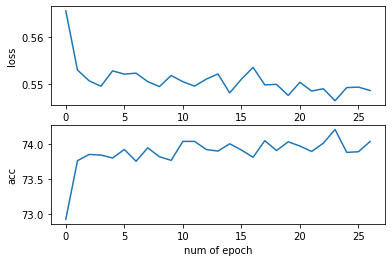

In [188]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(loss)),loss)
axs[1].plot(range(len(accuracy)),accuracy)

plt.setp(axs[1], xlabel='num of epoch')

plt.setp(axs[0], ylabel='loss')
plt.setp(axs[1], ylabel='acc')

plt.show() 

In [192]:
test_loss,test_accuracy,f1 = evaluate_model(model, test_data_iterator, criterion)
print(f"Test Loss {test_loss:.3f} Test accuracy {test_accuracy:.3f} F1 score {f1:.3f}")

Test Loss 0.670 Test accuracy 83.085 F1 score 0.096


In [197]:
pre_recall = calculate_f1_score(next(iter(test_data_iterator)),len(edits.vocab))
print(pre_recall)

tensor([0.0000, 0.8061, 0.8259, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])


### Rough work

In [ ]:
l=['plus', ',', 'the', 'novelty', 'of', 'the', 'iphone', 'won', "'t", 'wear', 'off', ',', 'as', 'it', 'may', 'with', 'a', 'camcorder', ';', 'and', 'over', 'these', 'video', 'apps', 'have', 'fun', 'effects', 'that', 'a', 'camcorder', 'can', "'t", 'match', '.']
l1=['$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$replace_might', '$keep', '$keep', '$keep', '$replace_,', '$keep', '$delete', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep']
print(len(l))
print(len(l1))

In [ ]:
a=[25, 13, 14, 29, 13, 13, 13, 25, 13, 13, 25, 21, 13, 13, 29, 13,  2,  2,
        13, 13, 13, 25]
b=[2, 2, 2, 3, 3, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
print(len(a))
print(len(b))

In [ ]:
n_embeddings, dim = 10,4 #10 - # of vocac size 4 - # of emdebbing dimension

In [ ]:
m = nn.Conv1d(1, 2, 3)
input = torch.randn(2, 1, 5) # (batch size, no. of channel, # of words)
# x = emb_1(input)
output = m(input)

In [ ]:
input.shape

In [ ]:
output.shape

In [ ]:
from torch.nn import Embedding as emb

emb_1 = emb(188, 50)
print(f"embedding {emb_1}")
print(f"embedding weight's shape {emb_1.weight.shape}") #requires_grad=True therefore the matrix is learnable

print(f"values of weight {emb_1.weight}")

for batch in train_data_iterator:
    x = emb_1(batch.tokens)

In [ ]:
x.shape

In [ ]:
x = torch.tensor([[1,2,4],[1, 2, 3]])
print(x.shape)
x=x.repeat(4, 2)
print(x.shape)


In [ ]:
import torch
import torch.nn as nn

In [ ]:
x_input = torch.randn([2,4,5])

# print(x_input)
x_input = x_input.permute(0,2,1).reshape(2,-1).unsqueeze(1)
print(x_input.shape)
print(x_input)

In [ ]:
a = nn.Conv2d(in_channels =1 ,out_channels= 1,kernel_size = 1)(x_input)
b = nn.Conv2d(in_channels =1 ,out_channels= 1,kernel_size = 2)(a)
c = nn.Conv2d(in_channels =1 ,out_channels= 1,kernel_size = 6)(b)

In [ ]:
print(f"a = {a.shape}")
print(f"b = {b.shape}")
print(f"c = {c.shape}")

In [ ]:
d = c.squeeze(1).reshape(2,5,-1)
d.shape


In [ ]:
print(f"f = {f.shape}")

In [ ]:
g = nn.Conv1d(in_channels =1 ,out_channels= 4,kernel_size = 3)(f)

In [ ]:
print(f"g = {g.shape}")

In [ ]:
a = torch.randn(2, 5, 4)
a

In [ ]:
torch.argmax(a, dim=1).shape

In [ ]:
torch.argmax(a, dim=-1)

In [ ]:
y_act = torch.Tensor([[[2,0,1],[2,0,1]],[[2,0,1],[2,0,1]]]).int()
# batch size, tokens, emb lay
# 2, 3, 3
y_pred = torch.argmax(torch.Tensor([[[[0,2,1],[4,2,1],[0,1,0]],[[0,0,1],[3,2,1],[0,1,0]]],[[[1,5,2],[3,2,1],[0,1,0]],[[1,5,2],[3,2,1],[0,1,0]]]]),dim=-1)
y_pred_1 = torch.argmax(torch.Tensor([[[1,5,2],[3,2,1],[0,1,0]],[[1,5,2],[3,2,1],[0,1,0]]]).reshape(-1,3),dim=1)

In [ ]:
print(y_pred)
print(y_act)

In [ ]:
precision_recall(y_pred,y_act,average=None,num_classes=3,mdmc_average='samplewise')

In [ ]:
print(accuracy_score(y_pred_1,y_act))

In [ ]:
x_input = torch.randn([2,4,5])

# print(x_input)
x_input = x_input.reshape(2,-1).unsqueeze(1)
print(x_input.shape)
print(x_input)

In [ ]:
b1 = nn.Conv1d(in_channels =1 ,out_channels= 2,kernel_size = 1,padding="same")(x_input)
c1 = nn.Conv1d(in_channels =2 ,out_channels= 6,kernel_size = 3,padding="same")(b1)
d1 = nn.Conv1d(in_channels =6 ,out_channels= 1,kernel_size = 5,padding="same")(c1)

In [ ]:
print(f"b1 = {b1.shape}")
print(f"c1 = {c1.shape}")
print(f"d1 = {d1.shape}")

In [ ]:
f = torch.cat((b1,c1,d1),1)

In [ ]:
f.shape

In [ ]:
a1 = nn.Conv1d(in_channels =4 ,out_channels= 4,kernel_size = 2,padding="same")(x_input)
b1 = nn.Conv1d(in_channels =4 ,out_channels= 4,kernel_size = 1,padding="same")(x_input)
c1 = nn.Conv1d(in_channels =4 ,out_channels= 4,kernel_size = 3,padding="same")(x_input)
d1 = nn.Conv1d(in_channels =4 ,out_channels= 4,kernel_size = 4,padding="same")(x_input)
e1 = torch.cat([a1,b1,c1,d1],dim =1)
f1 = nn.Conv1d(in_channels = e1.shape[1],out_channels= 25,kernel_size = 1)(e1)

In [ ]:
pooled1 = [a1,b1,c1,d1]

In [ ]:
print(f"e1 = {e1.shape}")

In [ ]:
print(f1.shape)

In [ ]:
x  = np.arange(0,10,1)
y1 = np.random.randn(10)
y3 = np.random.randn(10)

# Create subplots
fig, ax = plt.subplots(2, 1, sharex='col')
ax[0].plot(x,y1)
ax[1].plot(x,y3)

In [ ]:
 torch.sqrt(torch.FloatTensor([0.5]))

In [ ]:

# print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
x_input = torch.randn([2,4,5])

# print(x_input)
x_input = x_input.reshape(2,-1).unsqueeze(1)
print(x_input.shape)
print(x_input)

In [ ]:
# Multiple conv 1D layers 
conv_layers = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                            out_channels= 1,
                                            kernel_size = filter_size,
                                            padding = "same") 
                                  for filter_size in [1,3,5]])

final_layer = nn.Linear(5*3, 3)

# Dropout layers
dropout = nn.Dropout(0.5)

In [ ]:

# tokens size is [batch_size, max sentence size in the batch/token size]
# token_embeddings = [2, 1, 4*5]
conved = x_input
for conv_layer in conv_layers:
    conved = F.relu(conv_layer(conved))
print(len(conved))
concat = dropout(torch.cat(conved, dim = 1))
# [batch size, embedding dimension*num_of_tokens*num_of_filter]

In [ ]:
concat.shape

In [ ]:
conved = concat.reshape(2,4,-1)
# conved = [batch_size, num_of_tokens, embedding_dimension*num_of_filters]
conved.shape

In [ ]:
output = final_layer(conved)

In [ ]:
d = {"tokens": ["Alistair", "Darling", "is", "expected", "to", "announce", "details", "of", 
                "tax", "cuts", "and", "plans", "to", "increases", "public", "spending"], 
     "labels": ["$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", 
                "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$TRANSFORM_VERB_VBZ_VB", "$KEEP", "$APPEND_."]}

In [ ]:
calculate_accuracy(test_data,tokens,edits,model,device)

In [ ]:
len(d["labels"])

In [ ]:
a = ["$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$KEEP", "$TRANSFORM_VERB_VBZ_VB", "$KEEP", "$APPEND_."] 
b = ['$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$keep', '$transform_verb_vbz_vb', '$keep', '$keep']

In [ ]:
for i,j in zip(a,b):
    print(i.lower()==j,end=" ")

In [ ]:
ran = torch.Tensor([[[1,2,10],[3,4,11]],[[5,6,12],[7,8,13]]])

In [ ]:
ran.shape

In [ ]:
ran.reshape(2,-1)

In [ ]:
sample_weights = [0] * len(train_data)

In [ ]:
x_input = torch.randn([2,4,5])
filterss = [2,3,4]
inf = 1
x_input = x_input.reshape(2,-1).unsqueeze(1)
print(x_input.shape)
# print(x_input)

conv_layers = nn.ModuleList()

for i,filter_size in enumerate(filterss):
    conv_layers.append(nn.Conv1d(in_channels = inf,out_channels= 10,
                                 kernel_size = filter_size,padding = "same"))
    inf = 10

con = x_input
print("in",con.shape)

for i, conv_layer in enumerate(conv_layers):
    #pass through convolutional layer
    print(f"{i} input {con.shape}")
    
    conved = F.relu(conv_layer(con))
    print(f"{i} iiiii {conved.shape}")
    conved = conved + con
    con = conved
    
            

In [ ]:
conv_layers

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
for i, (data,label) in enumerate(train_data_iterator):
    print(label)
    break
class_weights= torch.Tensor([1/value for key,value in edits.vocab.freqs.items()])


In [ ]:
l1 = [batch.edits for batch in train_data_iterator]
l1 = [lst for edit in l1 for lst in edit]


In [ ]:
l1

In [ ]:
for data in train_data_iterator:
        if len(files) > 0:
            class_weights.append(1/len(files))


In [ ]:
for idx, (token, edit) in enumerate(train_data):
    class_weight = sum([class_weight for class_weight in eidts])
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
x_

###  THE END